# TRIQS Green's functions

It is now time to start using some of the tools provided by TRIQS.

Much of the functionality in TRIQS, while implemented in C++ for optimal performance, is exposed
through a Python interface to make it easier to use. From a practical point of view this means
that you can think of TRIQS as a python library, just like numpy or matplotlib.

One of the central objects of a many-body calculation is a Green's function.
Green's functions in TRIQS are functions defined on a mesh $\cal{M}$ of points that hold values in some domain $\cal{D}$, for example $\mathbb{C}^{2\times2}$

$$
G: \cal{M} \rightarrow \cal{D}
$$

A few common Green's function meshes in TRIQS include:

- `MeshReFreq` - Real-frequencies equally spaced in $[\omega_{min},\omega_{max}]$
- `MeshImFreq` - Matsubara Frequencies
- `MeshImTime` - Imaginary time points equally spaced in $[0,\beta]$
- `MeshReTime` - Real-time points (not covered in this tutorial)

Let's see how we can **construct a Mesh and print its values**.

In [1]:
# Import the Mesh type we want to use
from triqs.gf import MeshImTime

# The documentation tells us which parameters we need to pass for the mesh construction
?MeshImTime

Init signature: MeshImTime(self, /, *args, **kwargs)
Docstring:     
Mesh of imaginary times

Mesh-points are evenly distributed in the interval [0,beta]
including points at both edges.

Parameters
----------
beta : float
    Inverse temperature
statistic : str
    Statistic, 'Fermion' or 'Boson'
n_tau : int
    Number of mesh-points
File:           ~/opt/triqs/lib/python3.11/site-packages/triqs/gf/meshes.cpython-311-darwin.so
Type:           type
Subclasses:     

In [2]:
# Provide the inverse temperature, Statistic, and number of points
tau_mesh = MeshImTime(beta=5, S='Fermion', n_tau=11)

# We can loop and print the mesh-point values
for tau in tau_mesh:
    print(tau.value)

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


Let us now **create and initialize a Green's function for a single atomic level** with energy $\epsilon$ in the grand-canonical ensemble with inverse temperature $\beta$

$$
G[\tau] = -\langle\cal{T}c(\tau) c^\dagger\rangle = -\frac{e^{-\tau \epsilon}}{1+e^{-\beta \epsilon}}
= -\frac{e^{\left(\beta \Theta(-\epsilon) -\tau\right) \epsilon}}{1+e^{-\beta |\epsilon|}}$$

In practice we use the second expression, as it avoids diverging exponentials for large values of $\beta$.
We first have a look at the documentation for `Gf`.

In [2]:
from triqs.gf import Gf
?Gf

Init signature: Gf(**kw)
Docstring:     
TRIQS Greens function container class

Parameters
----------

mesh: Types defined in triqs.gf beginning with 'Mesh'
      The mesh on which the Green function is defined.

data: numpy.array, optional
      The data of the Greens function.
      Must be of dimension ``mesh.rank + target_rank``.

target_shape: list of int, optional
              Shape of the target space.

is_real: bool
         Is the Greens function real valued?
         If true, and target_shape is set, the data will be real.
         Mutually exclusive with argument ``data``.

name: str 
      The name of the Greens function for plotting.

Notes
-----

One of ``target_shape`` or ``data`` must be set, and the other must be `None`.
File:           ~/opt/triqs/lib/python3.11/site-packages/triqs/gf/gf.py
Type:           AddMethod
Subclasses:     GfReFreq, GfImFreq, GfImTime, GfReTime, GfLegendre

In [4]:
# Create scalar-valued imaginary-time Green's function
G = Gf(mesh=tau_mesh, target_shape=[], is_real=True)

# Print the Green's function description
print(G)

# Loop initialization
eps = -0.4
beta = G.mesh.beta
from math import exp
for tau in G.mesh:
    G[tau] = -exp((beta*(eps<0) - tau.value) * eps) / (1. + exp(-beta * abs(eps)))
    print("{:.3f}".format(G[tau]))

Greens Function  with mesh Imaginary Time Mesh with beta = 5, statistic = Fermion, n_tau = 11 and target_shape (): 

-0.119
-0.146
-0.178
-0.217
-0.265
-0.324
-0.396
-0.483
-0.590
-0.721
-0.881


In order to **plot this Green's function** we can use the matplotlib interface defined in TRIQS.
Note that the function to plot Green's function is `oplot` and not just `plot` like in matplotlib.

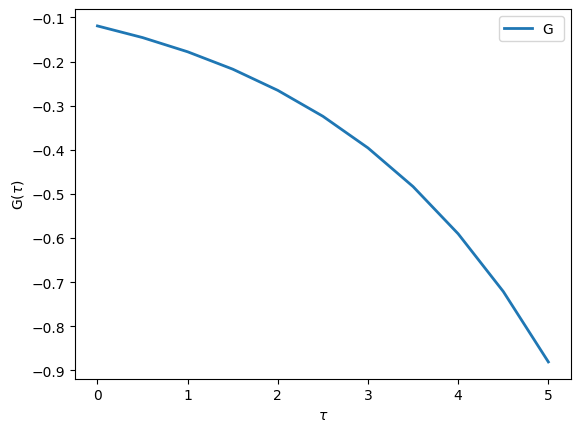

In [5]:
from triqs.plot.mpl_interface import oplot,plt

# Make plots show up directly in the notebook:
%matplotlib inline

# Make all figures slightly bigger
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

# Additional arguments like 'linewidth' are passed on to matplotlib
oplot(G, '-', name='G', linewidth=2)

## Matrix-Valued Green's functions

In most realistic problems we have to treat more than just a single orbital

$$
G_{ij}[\tau] = -\langle\cal{T}c_i(\tau) c_j^\dagger\rangle
$$

For this purpose, TRIQS provides Green's functions that have a Matrix structure. Let's see how you can create and use them

In [6]:
# A uniform real-frequency mesh on a given interval
from triqs.gf import MeshReFreq
w_mesh = MeshReFreq(window=(-4,4), n_w=1000)

# Gf with 2x2 Matrix structure holding complex values
G = Gf(mesh=w_mesh, target_shape=[2,2])
G # <- Same as print(repr(G))

Greens Function  with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (2, 2): 

In [7]:
# Accessing a specific mesh point gives us a matrix
from triqs.gf import Idx # Use Idx to access Gf at specific Index
print(G[Idx(0)])

[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [8]:
# By Fixing the orbital indices we obtain a Green's function that is no longer matrix but complex-valued
G[0,0]

Greens Function  with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (): 

## Block Green's functions

In many realistic problems we know a priori that (due to e.g. symmetries or conserved quantum numbers) certain components of the Green's function will vanish.
In other words, the Green's functions has an additional *block structure*.

$$
\hat{G} =
\begin{pmatrix}
\hat{g}^0 & 0 & \cdots & \cdots \\
0 & \hat{g}^1 & 0 & \cdots \\
\cdots & 0 & \hat{g}^2 & 0 \\
\cdots & \cdots & \cdots & \cdots
\end{pmatrix}
$$

Here the $\hat{g}^i$ are Green's functions with non-zero elements $g^i_{ab}$. In principle they can have
different dimensions.

For example, you can imagine a system of 5 $d$-orbitals that are split by a
crystal field into 3 $t_{2g}$-orbitals and 2 $e_g$-orbitals. For symmetry reasons, you can have a
situation where these orbitals do not talk to each other. In that case, the complete Green's function
would have two blocks, one of size 2x2 corresponding to the $e_g$ orbitals and one of size 3x3 corresponding for the $t_{2g}$ orbitals. 

$$
\hat{G} =
\begin{pmatrix}
\hat{g}^{e_g} & 0  \\
0 & \hat{g}^{t_{2g}}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
g^{e_g}_{00} & g^{e_g}_{01} \\
g^{e_g}_{10} & g^{e_g}_{11}
\end{pmatrix} & 0 \\
0 & \begin{pmatrix}
g^{t_{2g}}_{00} & g^{t_{2g}}_{01} & g^{t_{2g}}_{02} \\
g^{t_{2g}}_{10} & g^{t_{2g}}_{11} & g^{t_{2g}}_{12} \\
g^{t_{2g}}_{20} & g^{t_{2g}}_{21} & g^{t_{2g}}_{22} \\
\end{pmatrix}
\end{pmatrix}
$$

Let us now consider a more concrete example for the case outlined above:
$$
\hat{G} =
\begin{pmatrix}
\begin{pmatrix}
\omega & V_1 \\
V_1 & \omega
\end{pmatrix}^{-1} & 0 \\
0 & \begin{pmatrix}
\omega - \epsilon_2 & 0 & V_2 \\
0 & \omega - \epsilon_2 & 0 \\
V_2 & 0 & \omega - \epsilon_2
\end{pmatrix}^{-1}
\end{pmatrix}
$$

The associated type in TRIQS is called `BlockGf`. Let us have a first look at it's documentation:

In [3]:
from triqs.gf import BlockGf
?BlockGf

Init signature: BlockGf(**kwargs)
Docstring:      Generic Green's Function by Block.
Init docstring:
* There are several possible constructors, which accept only keyword arguments.

         * BlockGf(block_list = list of blocks, name_list = list of names, make_copies = False)

                * ``block_list``: list of blocks of Green's functions.
                * ``name_list``: list of the names of the blocks, e.g. ["up","down"]. Default to ["0", "1", ...]
                * ``make_copies``: If True, build the Green's function from a copy of the blocks (default: False).

         * BlockGf(mesh = mesh, gf_struct = block structure, target_rank = rank of target space)

                * ``mesh``: The mesh used to construct each block
                * ``gf_struct``: List of pairs [ (str,int), ... ] providing the block name and its linear size
                * ``target_rank``: The rank of the target space of each block (default: 2)

         * BlockGf(name_block_generator, make_copies =

We will in the following consider the first two options for the construction listed in the documentation.

The first way is to simply define the two Green's function blocks separately, and to then pass these blocks, together with their names:

In [10]:
# Construct individual blocks
g_eg  = Gf(mesh=w_mesh, target_shape=[2,2])
g_t2g = Gf(mesh=w_mesh, target_shape=[3,3])

# Combine blocks into a BlockGf
G = BlockGf(name_list=['eg', 't2g'], block_list=[g_eg, g_t2g])
print(G)

Green Function G composed of 2 blocks: 
 Greens Function G_eg with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (2, 2): 
 
 Greens Function G_t2g with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (3, 3): 
 



We can then access individual blocks simply by using their name

In [11]:
G['eg']

Greens Function G_eg with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (2, 2): 

For cases where all blocks have a square-matrix `target_shape` we can alternatively pass a list of pairs of block-names and linear matrix sizes.

In [12]:
# List of Block-names and their linear matrix size
gf_struct = [('eg',2), ('t2g',3)]

G = BlockGf(mesh=w_mesh, gf_struct=gf_struct)
print(G)

Green Function G composed of 2 blocks: 
 Greens Function G_eg with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (2, 2): 
 
 Greens Function G_t2g with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (3, 3): 
 



Let us now initialize the Green's function values. Instead of writing a loop over the mesh, we here make use of the the operator `<<`, which can fill the Green's function with simple expressions containing the `Omega` descriptor. Here `Omega` is replaced by the values of the mesh.

In [13]:
from triqs.gf import Omega

V1 = 0.1
V2 = 0.2
eps_t2g = -2.0

# The e_g part
G['eg'][0,0] << Omega
G['eg'][0,1] << V1
G['eg'][1,0] << V1
G['eg'][1,1] << Omega

# Perform an in-place Matrix inversion
G['eg'].invert()

# The t_2g part
G['t2g'][0,0] << Omega - eps_t2g
G['t2g'][1,1] << Omega - eps_t2g
G['t2g'][2,2] << Omega - eps_t2g
G['t2g'][0,2] << V2
G['t2g'][2,0] << V2
G['t2g'].invert()

When using the Green's function object, it is often convenient to **iterate over all the blocks** of a `BlockGf`. We can do this with the following construct

In [14]:
# Loop over the blocks
for name, g in G:
    print("This is the block called", name)
    print("The associated Green's function is", g)

This is the block called eg
The associated Green's function is Greens Function G_eg with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (2, 2): 

This is the block called t2g
The associated Green's function is Greens Function G_t2g with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (3, 3): 



## Additional Initialization Descriptors

In the following we will introduce a few additional means of initializing Green's functions using `<<`.

### Flat density of states
Consider the problem of a single impurity level embedded in a flat conduction bath $\Gamma$ of electrons.
$$
g^\mathrm{imp} (\omega) = \frac{1}{\omega - \epsilon_d - V^2 \Gamma(\omega)}
$$

In the equation above $\epsilon_d$ is the energy of the level and $\Gamma$ is the Green's function of
a flat conduction bath

$$
\Gamma(\omega) = \int_{-D}^{D}\frac{1}{\omega-\epsilon + i\eta}\frac{d\epsilon}{2D}
$$

Here $D$ denotes the half-bandwidth.
Let's see how to define and then plot this Green's function by using `inverse` and the `Flat` descriptor.

In [15]:
eps_d = 1.0 # Energy
V = 0.2   # Bath Hybridization
D = 1.5   # Half bandwidth

G = Gf(mesh=w_mesh, target_shape=[])

from triqs.gf import Omega, Flat, inverse
G << inverse(Omega - eps_d - V**2 * Flat(D))

Greens Function  with mesh Real Freq Mesh with w_min = -4, w_max = 4, n_w = 1000 and target_shape (): 

Note the predefined function `Flat` for a flat conduction bath $\Gamma(\omega)$.
Let's plot the impurity Green's function. Note that default, both the real and imaginary parts are plotted.

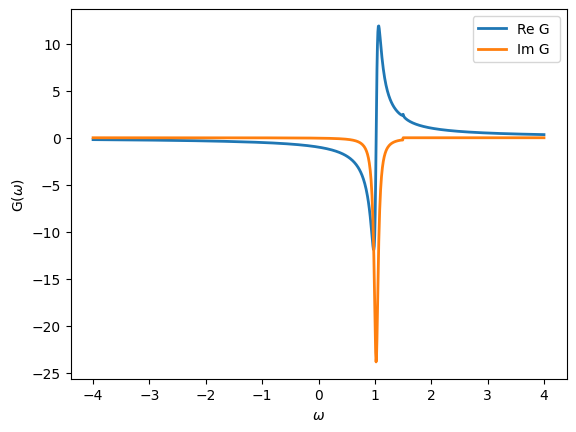

In [16]:
oplot(G, '-', linewidth=2, name="G") 

We can plot the spectral function, which is defined as

$$ \rho(\omega) = -\frac{1}{\pi} \, \textbf{Im} \, G $$

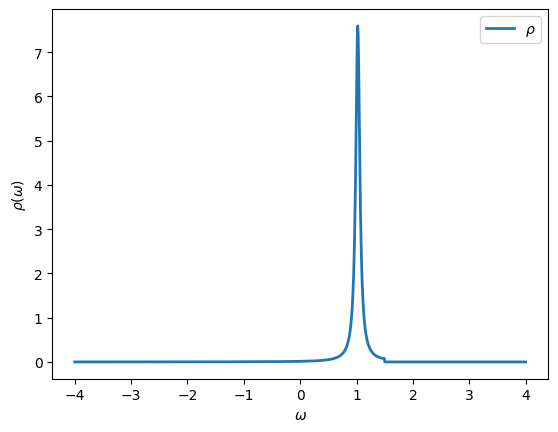

In [17]:
from math import pi
oplot(-G.imag/pi, linewidth=2, name=r"$\rho$")

As expected the spectral function is peaked at $\epsilon_d$ and shows a jump in spectral weight at $D$.

### Semi-circular density of states

Another predefined Green's function is the one corresponding to a semi-circular spectral function. This one will be useful in the DMFT Tutorials later on.

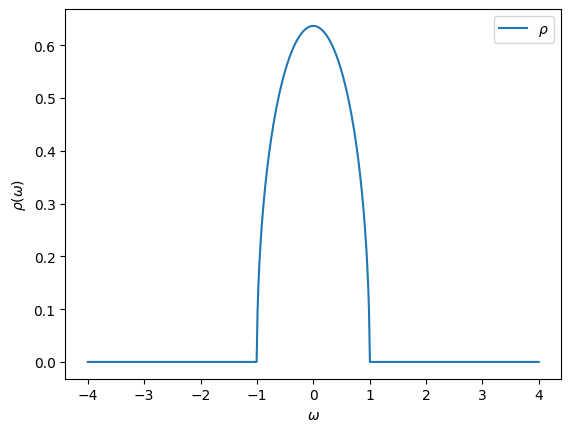

In [18]:
D = 1.0 # Half bandwidth

G = Gf(mesh=w_mesh, target_shape=[])

from triqs.gf import SemiCircular
G << SemiCircular(D)

oplot(-G.imag/pi, name=r"$\rho$") 

Imaginary-frequency Green's functions
-------------------------------------

These are Green's function defined on the Matsubara axis. The fermionic Matsubara frequencies
are defined by

$$\omega_n = \frac{(2n+1)\pi}{\beta}$$

where $\beta = 1/T$ is the inverse temperature. These Green's functions are important because
most Monte Carlo algorithms yield results on the Matsubara axis. Let's see how they
are defined:

(0.0, 10.0)

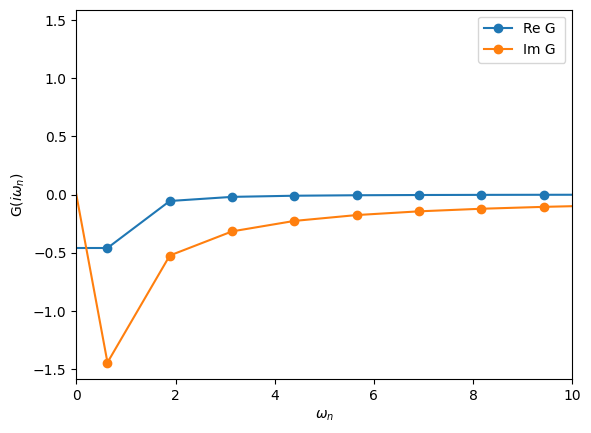

In [19]:
# Define the imaginary-frequency mesh
from triqs.gf import MeshImFreq
iw_mesh = MeshImFreq(beta=5, S='Fermion', n_iw=1000)

# Create Green's function and fill it using the iOmega_n descriptor
G = Gf(mesh=iw_mesh, target_shape=[])
from triqs.gf import iOmega_n
G << inverse(iOmega_n - 0.2)

# Plot the Green's function
oplot(G, '-o', name='G')
plt.xlim(0,10)

## Arithmetic Operations

Green's functions can be added, multiplied by numbers, etc. The way this is done is quite natural.

(0.0, 10.0)

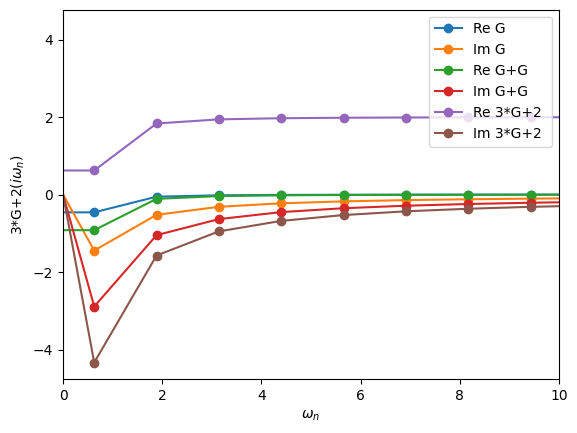

In [20]:
oplot(G, "-o", name='G')
oplot(G+G, "-o", name='G+G')
oplot(3*G+2, "-o", name='3*G+2')
plt.xlim(0,10)

## Obtaining the density

You can obtain the density for Green's functions with a `MeshReFreq` and `MeshImFreq` using the `density` method

In [21]:
G = Gf(mesh=iw_mesh, target_shape=[])
G << inverse(iOmega_n - 0.2)
print("Density =", G.density())

Density = (0.26894142138025784+1.816357384858482e-15j)


Do not worry about the imaginary component as the machine precision is on the order of $10^{-15}$.

## Fourier transforms

TRIQS allows you to easily Fourier transform Green's functions from imaginary-time to imaginary-frequency.

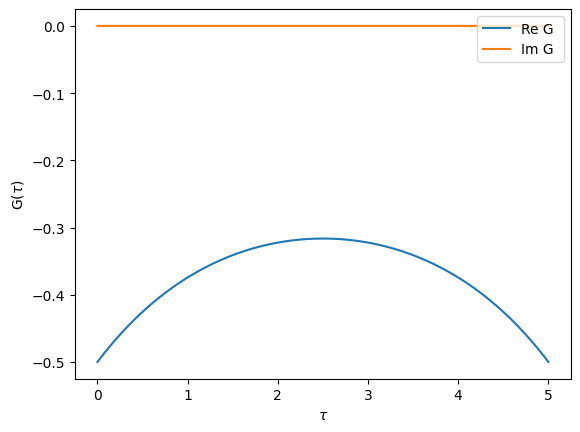

In [22]:
# A Green's function in frequency set to semi-circular
Giw = Gf(mesh=iw_mesh, target_shape=[])
Giw << SemiCircular(1.0)

# A Green's function in time set by inverse Fourier transform
from triqs.gf import make_gf_from_fourier
Gtau = make_gf_from_fourier(Giw)
oplot(Gtau, name='G')

We can also go the other way. Let's check that it gives back the original result.

(0.0, 5.0)

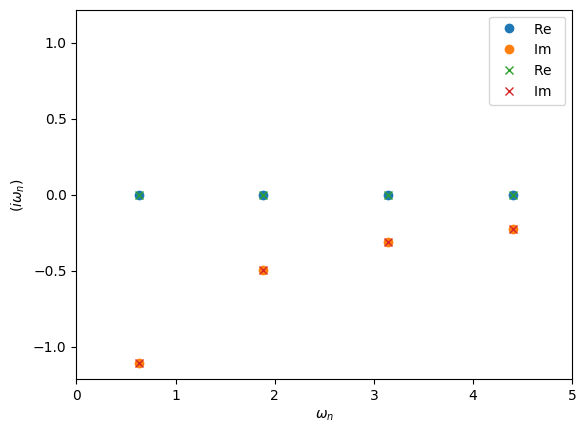

In [23]:
Giw_2 = make_gf_from_fourier(Gtau)
oplot(Giw, 'o')
oplot(Giw_2, 'x')
plt.xlim(0,5)

In the example above `make_gf_from_fourier` will construct a new Green's function object.
This uses the `statistic` information of `MeshImTime` to decide wether to use bosonic or fermionic Matsubara frequencies.
If we want to instead use an existing Green's function we can use the `Fourier` descriptor

In [24]:
from triqs.gf import Fourier
Gtau << Fourier(Giw)

Greens Function  with mesh Imaginary Time Mesh with beta = 5, statistic = Fermion, n_tau = 6001 and target_shape (): 

## Compact meshes for imaginary time / frequency: DLR Green's function

When representing Green's functions at low temperatures the regular meshes `MeshImFreq` and `MeshImTime` may easily require several thousand of points to store the relevant information. This is often problematic when storing or initializing lattice Green's functions
with a momentum and orbital dependence.

For this purpose TRIQS provides mesh types on the Matsubara / imaginary time axis that are much more compact,
based on the Discrete Lehman Representation (DLR), for a detailed introduction see [Kaye et al., PRB105, 2022](https://doi.org/10.1103/PhysRevB.105.235115).

The DLR of an imaginary time Green's function is given by an expansion of the form

$$ G(\tau) \approx \sum_{l=1}^r K(\tau, \omega_l) \, \widehat{g}_l $$

where $K(\tau,\omega) = -\frac{e^{-\tau \omega}}{1+e^{-\beta \omega}}$ is the analytic continuation kernel appearing in the spectral Lehmann representation

$$ G(\tau) = \int_{-\infty}^\infty d\omega \, K(\tau, \omega) \rho(\omega) $$

relating $G$ to its spectral density $\rho$. 

The DLR frequencies $\omega_l$ are obtained by a numerical scheme that is independent of the specific Green's function $G$. They depend only on the desired accuracy $\epsilon$ of the DLR expansion, and a dimensionless cutoff parameter $\Lambda = \beta \omega_{max}$ characterized by the assumption that $\rho(\omega) = 0$ outside of the interval $[-\omega_{max}, \omega_{max}]$. The DLR basis is one of the most compact representations of Matsubara Green's functions and the basis size scales only logarithmically with $\beta$.

To get started we first create a Matsubara Green's function with a SemiCircular density of states function at a low temperature of $\beta=100$. For the imaginary part of G to decay to zero we have to use as many as `~1500` Matsubara frequencies.

In [25]:
iw_mesh = MeshImFreq(beta=100, S='Fermion', n_iw=1500)
Giw = Gf(mesh=iw_mesh, target_shape=[])
Giw << SemiCircular(1.0)

Greens Function  with mesh Imaginary Freq Mesh with beta = 100, statistic = Fermion, n_iw = 1500, positive_only = false and target_shape (): 

We now construct a DLR Matsubara Green's function. Similar to the MeshImFreq we have to provide $\beta$ and the particle statistics. Additionally we set the maximal spectral width of the Greens function `w_max` (half spectral width), plus the precision we want to achieve with the DLR basis:

In [26]:
# import DLR mesh
from triqs.gf.meshes import MeshDLRImFreq

dlr_iw_mesh = MeshDLRImFreq(beta=100, statistic='Fermion', w_max=1.2, eps=1e-15)
# the Gf is constructed then the same way
Giw_dlr = Gf(mesh= dlr_iw_mesh, target_shape=[])

print(dlr_iw_mesh)

DLR imfreq mesh of size 43 with beta = 100, statistic = Fermion, w_max = 1.2, eps = 1e-15


By printing the mesh we see that its size is `43` which is substantially smaller than `1500`.
We can initialize the DLR Matsubara Green's function using the same syntax as before

In [27]:
Giw_dlr << SemiCircular(1.0);

Let us now plot both Green's functions:

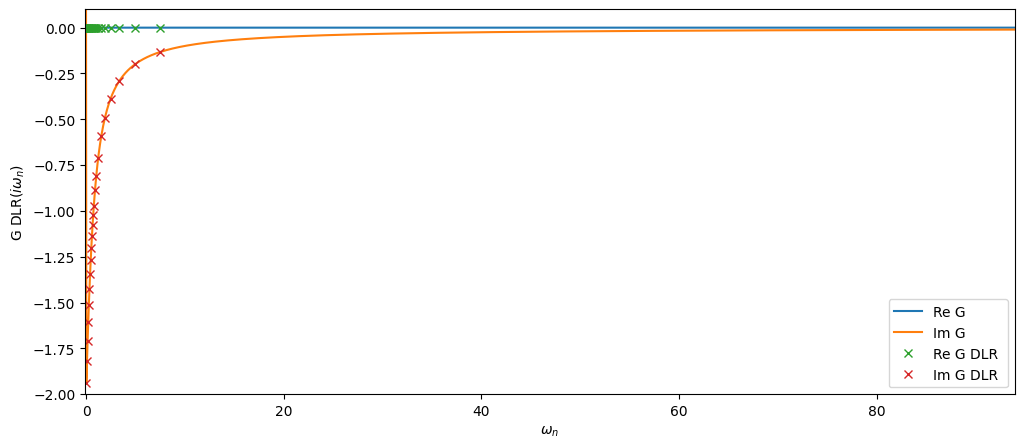

In [28]:
fig, ax = plt.subplots(1,figsize=(12,5))
oplot(Giw, "-", name='G')
oplot(Giw_dlr, name='G DLR')
plt.xlim(-0.1,94)
plt.ylim(-2,0.1)
plt.legend(loc='lower right');

The DLR mesh Matsubara nodes are quite sparse but as we will see below the data is sufficient to reconstruct the full Matsubara mesh up to the precision specified. 

Next we create the DLR coefficient Green's function associated with `Giw_dlr`. This form is central as it can be easily converted into a `Gf` with any of the mesh types `MeshImTime`, `MeshImFreq`, `MeshDLRImTime` and `MeshDLRImFreq`.

We obtain the Green's function on the full Matsubara mesh using the function `make_gf_imfreq` to then compare it against the original `Giw`. 

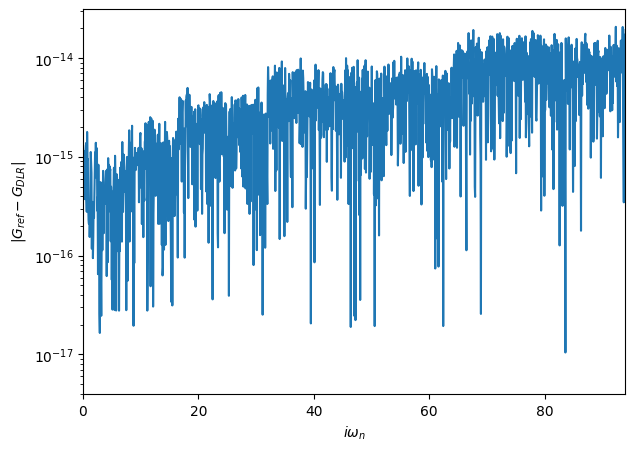

In [29]:
# import helper functions
from triqs.gf import make_gf_dlr, make_gf_dlr_imtime, make_gf_imfreq, make_gf_imtime

# create DLR coefficient Green's function
G_dlr = make_gf_dlr(Giw_dlr)

# Get back Green's function on the full Matsubara mesh, no Fourier transform needed
Giw_from_dlr = make_gf_imfreq(G_dlr, n_iw=1500)

# plot the difference between the original
fig, ax = plt.subplots(1,figsize=(7,5))

mesh = [iw.imag for iw in Giw.mesh.values()]
ax.plot(mesh, abs((Giw_from_dlr-Giw).data))
ax.semilogy()
ax.set_xlim(0,94)
ax.set_xlabel(r'$i\omega_n$')
ax.set_ylabel(r'$|G_{ref}-G_{DLR}|$');

The given accuracy `eps=1e-15` is reached over the full Matsubara mesh!

The coefficient DLR mesh Gf can be evaluated on any given tau point by passing the Gf a float:

In [30]:
G_dlr(1.2)

(-0.31556737050747535-9.638049093627782e-17j)

or on the Matsubara axis by passing a Matsubara mesh point:

In [31]:
G_dlr(iw_mesh(0))

(6.83481049534862e-16-1.9381548639656863j)

Finally we can also construct an imaginary time Green's functions, using `make_gf_dlr_imtime` on the compact mesh, and using `make_gf_imtime` on arbirarily dense $\tau$ meshes by passing the parameter `n_tau`:

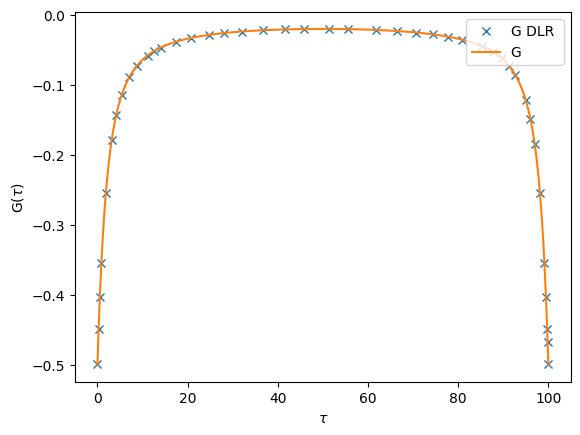

In [32]:
Gtau_dlr = make_gf_dlr_imtime(G_dlr)
Gtau = make_gf_imtime(G_dlr, n_tau=5001)

oplot(Gtau_dlr.real, name='G DLR')
oplot(Gtau.real, name='G')

## Pade analytical continuation

The Fourier transforms allow to go from time to frequency. A much more delicate thing is to do the so-called "analytical continuation". This means to start from a Matsubara-frequency Green's function and obtain the corresponding real-frequency Green's function. This can formally be done, but turns out to be a mathematically ill-conditioned problem. Even small amounts of noise in the Matsubara-frequency data will make the continuation to the real axis very unstable.

One of the ways to do perform analytical continuation is to use [Pade approximants](https://en.wikipedia.org/wiki/Padé_approximant#Definition). TRIQS can do that for you in the following way:

*Note:* Pade is currently implemented only for Green's functions with a Matrix structure

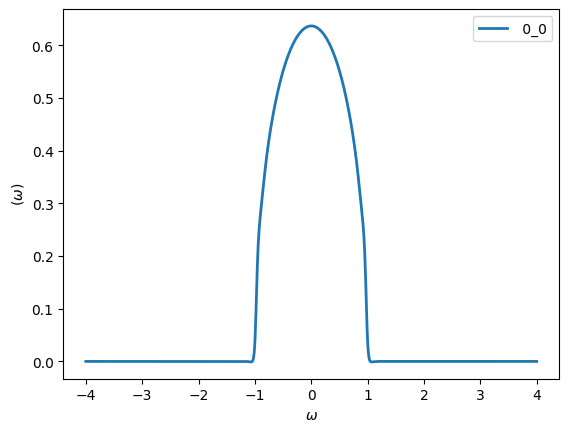

In [33]:
# The Matsubara Green's function to be continued
iw_mesh = MeshImFreq(beta=50, S='Fermion', n_iw=1000)
Giw = Gf(mesh=iw_mesh, target_shape=[1,1])
Giw << SemiCircular(1.0)

# Construct real-frequency Green's function and initialize it using Pade approximants
Gw = Gf(mesh=w_mesh, target_shape=[1,1])
Gw.set_from_pade(Giw)

oplot(-Gw.imag/pi, linewidth=2)

The coarse Matsubara discretization at high temperatures will worsen the Pade result, which is why we chose a much lower temperature value for this example.

You can see that the Pade continuation did a pretty good job. We will see later that noise will completely change this picture!

## Exercises

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1

Define the following real-frequency Green's function, where $\Gamma$ is the Green's function of a
flat bath (width = 1), $\epsilon_d = 0.3$ and $V=0.2$:

$$
G^\mathrm{s+d} (\omega) =
\begin{pmatrix} \omega - \epsilon_d & V \\\\ V & \Gamma^{-1}
\end{pmatrix}^{-1}
$$

Plot the spectral function for both diagonal components of this Green's function. What
do they represent physically?

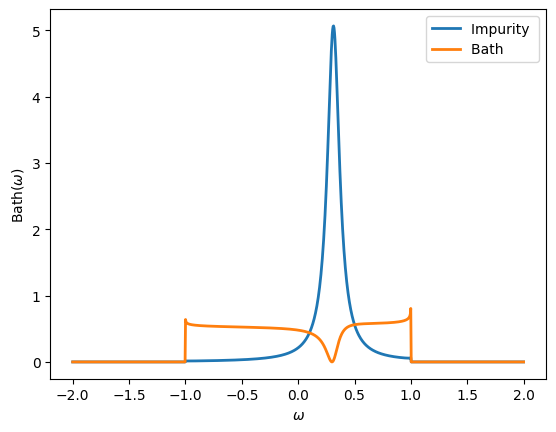

In [34]:
# Parameters
eps_d, V = 0.3, 0.2

# Construct and Initialize Gf
w_mesh = MeshReFreq(window=(-2,2), n_w=1000)
G = Gf(mesh=w_mesh, target_shape=[2,2])
G[0,0] << Omega - eps_d
G[0,1] << V
G[1,0] << V
G[1,1] << inverse(Flat(1.0))
G.invert()

# Plot
oplot(-G[0,0].imag/pi, '-', lw=2, name = "Impurity")
oplot(-G[1,1].imag/pi, '-', lw=2, name = "Bath")

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2

Plot the density $n(\epsilon)$ as a function of $\epsilon$ for a Green's function $G = 1/(i\omega_n - \epsilon)$. What is the curve that you obtained? How does it change with temperature?

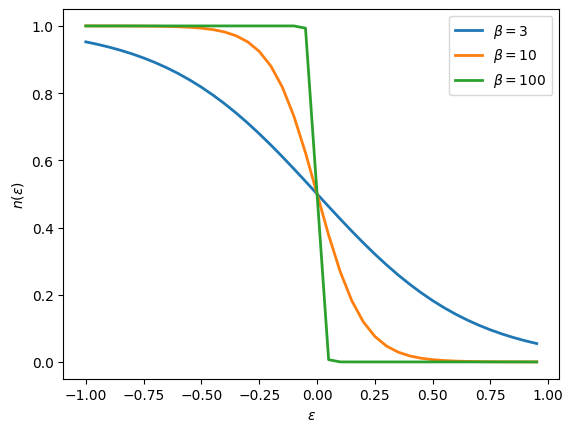

In [35]:
# Consider various temperatures
for beta in [3, 10, 100]:
    
    # Construct Gf
    iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=1000)
    G = Gf(mesh=iw_mesh, target_shape=[])
    
    # Initialize and plot for different epsilon
    import numpy
    eps_r = numpy.arange(-1,1,0.05)
    n_r = []
    for eps in eps_r:
        G << inverse(iOmega_n - eps)
        n_r.append(G.density().real)
    plt.plot(eps_r, n_r, lw=2, label=r"$\beta = %i$"%beta)
    
plt.xlabel('$\epsilon$')
plt.ylabel('$n(\epsilon)$')
plt.legend()

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3

Define a block Green's function with an *up* and a *down* block. Each block is just a simple 1x1 imaginary-frequency Green's function. Iterate over the blocks to initialize the two blocks to $1/i \omega_n$. What happens if you change $\beta$?

Text(0, 0.5, 'Im G[$\\beta$]')

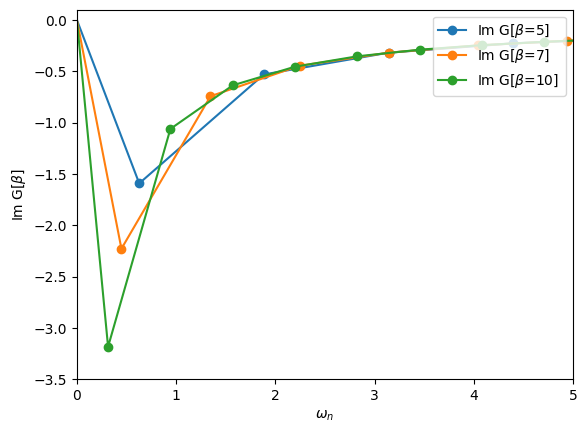

In [36]:
# Consider various temperatures
for beta in [5, 7, 10]:
    iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=1000)
    G = BlockGf(mesh=iw_mesh, gf_struct=[('up',1),('down',1)])

    # Loop over the blocks to initialize
    for name, g in G:
        g << inverse(iOmega_n)
        
    # Plot one entry
    oplot(G["up"][0,0].imag, '-o', name=r"Im G[$\beta$={}]".format(beta))
    
plt.xlim(0,5)
plt.ylim(-3.5,0.1)
plt.ylabel(r"Im G[$\beta$]")

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 4

Consider a Hubbard atom with $U=2$ at temperature $T = 1/\beta = 1/10$. The non-interacting and interacting Green's functions for this problem are:

$$
G_0 = \frac{1}{i \omega_n + U/2} \qquad G = \frac{1}{2(i\omega_n + U/2)} + \frac{1}{2(i\omega_n - U/2)}
$$

Using Dyson's equation, verify that the corresponding self-energy is indeed

$$
\Sigma = \frac{U}{2} + \frac{U^2}{4 i\omega_n}
$$

(0.0, 10.0)

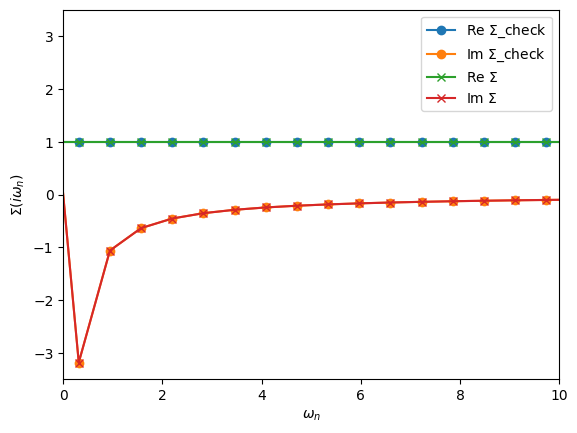

In [37]:
# Parameters
U = 2.0

# Green's function containers
iw_mesh = MeshImFreq(beta=10, S='Fermion', n_iw=1000)
G_0 = Gf(mesh=iw_mesh, target_shape=[])
G = G_0.copy()
Sigma = G_0.copy()
Sigma_check = G_0.copy()

# Green's functions of the Hubbard atom
G_0 << inverse(iOmega_n + U/2)
G << 0.5*inverse(iOmega_n + U/2) + 0.5*inverse(iOmega_n - U/2)

# Dyson's equation to find the self-energy
Sigma << inverse(G_0) - inverse(G)

# Known solution
Sigma_check << U/2 + U*inverse(2*iOmega_n)

oplot(Sigma_check, '-o', name=r'$\Sigma$_check')
oplot(Sigma, '-x', name=r'$\Sigma$')
plt.xlim(0,10)

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 5

Compute the following second-order self-energy with $U=2$ and $\beta=50$

$$ \Sigma(i\omega_n) = U^2 \int_0^\beta d\tau e^{i \omega_n \tau} G_0(\tau)^3 $$

using an non-interacting $G_0$ given by a semi-circular of half-bandwidth 1. Use Dyson's equation to compute $G(i\omega_n)$.

Hint: The `SemiCircular` initializer only works for frequency Green's functions.

Hint: The "power operator" is not defined for Green's functions. Use multiplication.

(0.0, 4.0)

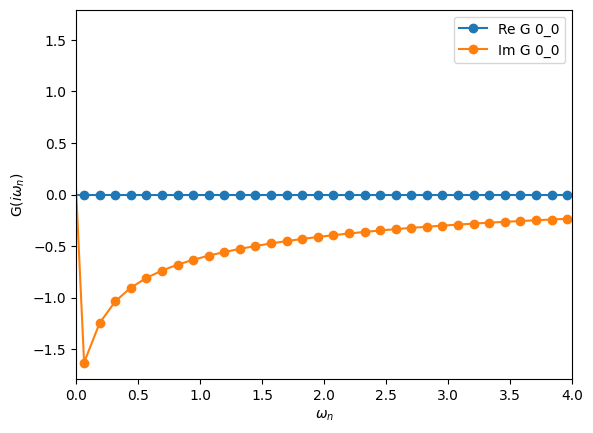

In [38]:
# Parameters
U = 2.0

# Define and initialize G0 in freq
iw_mesh = MeshImFreq(beta=50, S='Fermion', n_iw=1000)
G0_iw = Gf(mesh=iw_mesh, target_shape=[1,1])
G0_iw << SemiCircular(1.0)

# Compute second-order self-energy
G0_tau = make_gf_from_fourier(G0_iw)
Sigma_tau = U**2 * G0_tau * G0_tau * G0_tau
Sigma_iw = make_gf_from_fourier(Sigma_tau)

# Dyson's equation
G_iw = G0_iw.copy()
G_iw << inverse(inverse(G0_iw) - Sigma_iw)

oplot(G_iw, '-o', name='G')
plt.xlim(0,4)

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 6

Use Pade approximants to obtain a real-frequency version of the Green's function computed in the Exercise 5. What is the effect of interactions at second-order perturbation theory? How is it changing with different values of $U$?

Text(0, 0.5, '$\\rho(\\omega)$')

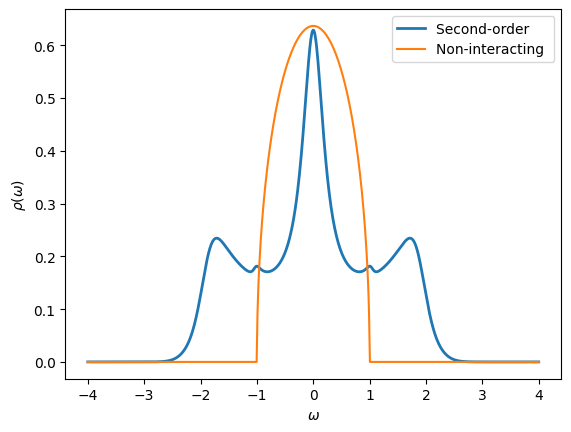

In [39]:
# Create Green's functions
w_mesh = MeshReFreq(window=(-4,4), n_w=1000)
G_w = Gf(mesh=w_mesh, target_shape=[1,1])
G0_w = G_w.copy()

# Initialize from Pade
G_w.set_from_pade(G_iw)
oplot(-G_w[0,0].imag/pi, lw=2, name="Second-order")

# Initialize non-interacting Green's function
G0_w << SemiCircular(1.0)
oplot(-G0_w[0,0].imag/pi, name="Non-interacting")

plt.ylabel(r"$\rho(\omega)$")